In [1]:
# import os
# import gc
import re
# import random
# import time
# import pickle
import logging
import multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import networkx as nx
from tqdm import tqdm

import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset#, random_split, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.preprocessing import StandardScaler#, MinMaxScaler, RobustScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, mean_squared_error
from sklearn.model_selection import train_test_split
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LinearRegression

# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.stattools import adfuller, acf, pacf, ccf

from gensim.models import Word2Vec
from gensim.utils import RULE_DEFAULT, RULE_KEEP
from gensim.models.callbacks import CallbackAny2Vec

# from scipy import sparse

# from typing import List, Tuple


In [2]:
def update_co_occurrences(word_year_list,word_co_occurrences):
    # Iterate through the words in the list
    word_list, year = word_year_list
    
    for word in word_list:
        # If the word is not already in the dictionary, add it with an empty list
        if word not in word_co_occurrences:
            word_co_occurrences[word] = {}
        
        # Add words from the list to the co-occurrence list for the current word
        for other_word in word_list:
            # if other_word != word and other_word not in word_co_occurrences[word]:
            #     word_co_occurrences[word].append(other_word)
            if other_word != word and other_word not in word_co_occurrences[word]:
                word_co_occurrences[word][other_word] = [year] 
            
            elif other_word != word and other_word in word_co_occurrences[word]:
                # word_co_occurrences[word][other_word][0] +=1
                word_co_occurrences[word][other_word].append(year)

def keep_words_with_underscore(input_string):
    # Define a regular expression pattern to match words with underscores
    pattern = r'\b\w*_[\w_]*\b'

    # Use re.findall to extract words that match the pattern
    matching_words = re.findall(pattern, input_string)

    # Join the matching words to form the final string
    result = ' '.join(matching_words)
    return result

In [54]:
ngram_abstracts = np.load("saved_files/ngram_abstracts.npy", mmap_mode="r")
filtered_concept_arr = np.unique(np.load("saved_files/overlapping_filtered_5_concepts.npy"))
year_arr = np.load("saved_files/year_arr.npy", mmap_mode="r")

In [3]:
df_ab = pd.DataFrame(data=ngram_abstracts,    # values
                columns=["ab"])  # 1st row as the column names
df_ab["year"] = year_arr

# Define important words
phys_concept_dict = {k:1 for k in filtered_concept_arr}

ocurr_arr = []
for abstract, year in zip(ngram_abstracts, year_arr):
    temp = keep_words_with_underscore(abstract)
    if temp.count(" ") > 0:
        temp = temp.split(" ") 
        temp = [s for s in temp if s in phys_concept_dict]
        ocurr_arr.append([list(filter(("_").__ne__, temp)),year])
                        
word_co_occurrences = {}
for word_list in tqdm(ocurr_arr):
    update_co_occurrences(word_list, word_co_occurrences)

100%|██████████| 63633/63633 [00:02<00:00, 29345.82it/s]


In [4]:
load = True 

year_train = 2017 #train_label_years => [2018, 2019, 2020]
year_test = 2020 # test_label_years => [2021, 2022, 2023]
if not load:

    # Custom rule function
    def custom_rule(word, count, min_count):
        if word in phys_concept_dict:
            return RULE_KEEP
        else:
            return RULE_DEFAULT

    cores = multiprocessing.cpu_count()

    class LossLogger(CallbackAny2Vec):
        '''Callback to log loss after each epoch.'''
        def __init__(self):
            self.epoch = 0
            self.losses = []
            self.previous_loss = 0
            self.initial_loss = 0

        def on_epoch_begin(self, model):
            # Record the initial loss at the start of each epoch
            self.initial_loss = model.get_latest_training_loss()

        def on_epoch_end(self, model):
            current_loss = model.get_latest_training_loss()
            # Calculate the loss for the current epoch
            loss = current_loss - self.initial_loss
            self.losses.append(loss)
            self.initial_loss = current_loss  # Reset for the next epoch
            self.epoch += 1

    

        
    ngram_abstracts_year = [ab.split() for ab in df_ab[df_ab['year'] <= year_train]["ab"].to_numpy()]
    loss_logger = LossLogger()
    w2v_model = Word2Vec(min_count=5,
                        window=15,
                        vector_size=128,
                        sample=1e-4, 
                        alpha=0.01, 
                        min_alpha= 0.0001, 
                        negative=15,
                        workers=cores-1)
    # Build the vocabulary on the first year's data
    w2v_model.build_vocab(ngram_abstracts_year, trim_rule=custom_rule)
    w2v_model.train(ngram_abstracts_year, total_examples=w2v_model.corpus_count, epochs=50, compute_loss=True, callbacks=[loss_logger])
    w2v_model.save(f"saved_models/baseline_1_train_model_{year_train}.model")

    ngram_abstracts_year = [ab.split() for ab in df_ab[df_ab['year'] <= year_test]["ab"].to_numpy()]
    loss_logger = LossLogger()
    w2v_model = Word2Vec(min_count=5,
                        window=15,
                        vector_size=128,
                        sample=1e-4, 
                        alpha=0.01, 
                        min_alpha= 0.0001, 
                        negative=15,
                        workers=cores-1)
    # Build the vocabulary on the first year's data
    w2v_model.build_vocab(ngram_abstracts_year, trim_rule=custom_rule)
    w2v_model.train(ngram_abstracts_year, total_examples=w2v_model.corpus_count, epochs=50, compute_loss=True, callbacks=[loss_logger])
    w2v_model.save(f"saved_models/baseline_1_test_model_{year_test}.model")

In [55]:
from gensim.models import KeyedVectors

def get_baseline_1_embeddings(loaded_w2v: KeyedVectors, phys_concept_dict: dict, embedding_dim: int = 128):
    """
    Extract embeddings for physical concepts from a Word2Vec model.

    Args:
        loaded_w2v (KeyedVectors): The preloaded Word2Vec model.
        phys_concept_dict (dict): Dictionary of physical concepts.
        embedding_dim (int): Dimensionality of the embeddings. Defaults to 128.

    Returns:
        tuple: A tuple containing:
            - np.ndarray: Array of concept embeddings.
            - np.ndarray: Array of concept identifiers.
    """
    c_dict = {}
    
    for c in phys_concept_dict:
        try:
            vec_enc = loaded_w2v.wv[c]  # Use direct indexing for simplicity
            c_dict[c] = vec_enc
        except KeyError:
            continue

    num_found = len(c_dict)
    num_missed = len(phys_concept_dict) - num_found
    print(f"Found {num_found} vectors, missed {num_missed} vectors.")
    
    if num_found == 0:
        return np.empty((0, embedding_dim)), np.empty((0,), dtype="<U55")

    c_encoding_arr = np.zeros((num_found, embedding_dim))
    c_inx_arr = np.zeros((num_found,), dtype="<U55")

    for cnt, (concept, encoding) in enumerate(c_dict.items()):
        c_encoding_arr[cnt] = encoding 
        c_inx_arr[cnt] = concept

    return c_encoding_arr, c_inx_arr

baseline_1_train_encoding_arr, baseline_1_train_c_arr = get_baseline_1_embeddings(Word2Vec.load(f"saved_models/baseline_1_train_model_{year_train}.model"),phys_concept_dict)

baseline_1_test_encoding_arr, baseline_1_test_c_arr = get_baseline_1_embeddings(Word2Vec.load(f"saved_models/baseline_1_test_model_{year_test}.model"),phys_concept_dict)


2024-08-04 12:57:32,315 - INFO - loading Word2Vec object from saved_models/baseline_1_train_model_2017.model
2024-08-04 12:57:32,329 - INFO - loading wv recursively from saved_models/baseline_1_train_model_2017.model.wv.* with mmap=None
2024-08-04 12:57:32,330 - INFO - setting ignored attribute cum_table to None
2024-08-04 12:57:32,423 - INFO - Word2Vec lifecycle event {'fname': 'saved_models/baseline_1_train_model_2017.model', 'datetime': '2024-08-04T12:57:32.423548', 'gensim': '4.3.2', 'python': '3.9.13 (main, Aug 25 2022, 23:26:10) \n[GCC 11.2.0]', 'platform': 'Linux-6.5.0-45-generic-x86_64-with-glibc2.35', 'event': 'loaded'}
2024-08-04 12:57:32,448 - INFO - loading Word2Vec object from saved_models/baseline_1_test_model_2020.model
2024-08-04 12:57:32,461 - INFO - loading wv recursively from saved_models/baseline_1_test_model_2020.model.wv.* with mmap=None
2024-08-04 12:57:32,462 - INFO - setting ignored attribute cum_table to None
2024-08-04 12:57:32,560 - INFO - Word2Vec lifecycle

Found 9934 vectors, missed 301 vectors.
Found 10172 vectors, missed 63 vectors.


In [70]:
# similarity_cosine(np.random.choice(baseline_1_train_encoding_arr),np.random.choice(baseline_1_train_encoding_arr))[0]
aaa


[0.1613820528800398,
 0.32338415699922424,
 -0.06582609016035569,
 0.15827089773175929,
 0.0784891981166732,
 0.09550957606975895,
 0.07506304065007421,
 0.31014132433572555,
 0.08969592491936489,
 0.5195501686770382,
 -0.07280688982005569,
 0.10723640671616619,
 0.39932312020836086,
 0.12261352050477052,
 0.15954382078986637,
 0.01494135143815298,
 0.5313000917090198,
 -0.12593486335995965,
 -0.0083101382341321,
 -0.1812047638690492,
 0.1561292687386481,
 0.1376889586567927,
 0.009938005601319558,
 0.03750354772136718,
 -0.20793603222098775,
 0.19772464999300857,
 0.1308876968143443,
 0.07599231415406418,
 -0.12854209358942348,
 0.2112423730483663,
 0.20410942608805688,
 0.12022451672077762,
 0.03824176384256605,
 -0.12306424855432507,
 0.3320062632748581,
 0.1905096013028731,
 0.04782337742412653,
 0.2382104823289742,
 0.544840337350808,
 -0.028343927428805107,
 0.06327384530524406,
 0.22036106733825933,
 -0.021399474078879606,
 0.2446899508626764,
 0.22129088839782102,
 0.1044689078

In [6]:
def get_co_occur_concept_pair_after_year_arr(word_co_occurrences: dict, first_occ_year: int, final_occ_year: int) -> np.ndarray:
    co_occur_concept_pair_arr = []
    for concept, v in word_co_occurrences.items():
        for co_concept, years in v.items():
            if np.min(years) >= first_occ_year and np.max(years) <= final_occ_year:
                co_occur_concept_pair_arr.append([concept,co_concept])
    return np.array(co_occur_concept_pair_arr)

def _get_years_range(start: int, end: int) -> np.ndarray:
        return (np.unique(year_arr)[start:] if end == -0 
                                 else np.unique(year_arr)[start:end])

def create_dataset_indexing(data: np.ndarray, word_co_occurrences: dict, year_arr: np.ndarray, c_inx_arr: np.ndarray, 
                 input_window_size: int = 5, output_window_size: int = 3, offset_to_current_year: int = 1):
    """
    Dataset indexing for time series data.

    Args:
        data (np.ndarray): The input data.
        word_co_occurrences (dict): Dictionary of word co-occurrences.
        year_arr (np.ndarray): Array of years.
        c_inx_arr (np.ndarray): Array of concept indices.
        input_window_size (int, optional): Size of the input window. Defaults to 5.
        output_window_size (int, optional): Size of the output window. Defaults to 3.
        offset_to_current_year (int, optional): Offset to the current year. Defaults to 1.
        print_test (bool, optional): Whether to print test information. Defaults to False.

    Returns:
        np.ndarray: Positive index pair array.
        np.ndarray: Negative index pair array.
    """
    train_window_data = data[:, -input_window_size-output_window_size-offset_to_current_year:-output_window_size-offset_to_current_year]
    label_year_range = (year_arr[-output_window_size:] if offset_to_current_year == 0 
                                else year_arr[-output_window_size-offset_to_current_year:-offset_to_current_year])

    co_occur_concept_pair_arr = get_co_occur_concept_pair_after_year_arr(
        word_co_occurrences, label_year_range[0], label_year_range[-1])
    
    print(f"Training Window: {_get_years_range(-input_window_size-output_window_size-offset_to_current_year, -output_window_size-offset_to_current_year)}")
    print(f"Label Window: {_get_years_range(-output_window_size-offset_to_current_year, -offset_to_current_year)}")

    # Precompute indices for each unique concept in c_inx_arr
    concept_to_indices = {concept: np.where(c_inx_arr == concept)[0] for concept in np.unique(c_inx_arr)}

    # Convert word_co_occurrences to a dictionary of sets for fast membership checking
    word_co_occurrences_set = {k: set(v) for k, v in word_co_occurrences.items()}

    pos_inx_pair_arr = np.zeros((len(co_occur_concept_pair_arr),2), dtype=int)
    
    for inx, pair in enumerate(co_occur_concept_pair_arr):
        try:
            pos_inx_pair_arr[inx, 0] = concept_to_indices[pair[0]][0]
            pos_inx_pair_arr[inx, 1] = concept_to_indices[pair[1]][0]
        except:
            pos_inx_pair_arr[inx, 0] = 0
            pos_inx_pair_arr[inx, 1] = 0
            
    
    pos_inx_pair_arr = pos_inx_pair_arr[~((pos_inx_pair_arr[:, 0] == 0) & (pos_inx_pair_arr[:, 1] == 0))]


    print("Finished Positives")
    
    neg_inx_pair_arr = np.zeros((len(pos_inx_pair_arr), 2), dtype=int)
    checked_pairs = set()
    neg_inx = 0

    while neg_inx < len(pos_inx_pair_arr):
        sampled_pair = tuple(np.random.choice(train_window_data.shape[0], size=2, replace=False))
        
        # Ensure the sampled pair is not the same and hasn't been checked before
        if sampled_pair not in checked_pairs:
            checked_pairs.add(sampled_pair)
            concept_0, concept_1 = c_inx_arr[sampled_pair[0]], c_inx_arr[sampled_pair[1]]

            if concept_1 not in word_co_occurrences_set.get(concept_0, set()):
                neg_inx_pair_arr[neg_inx, 0] = concept_to_indices[concept_0][0]
                neg_inx_pair_arr[neg_inx, 1] = concept_to_indices[concept_1][0]
                neg_inx += 1
    print("Finished Negatives")
    
    save_pos_arr = [word_co_occurrences[c_inx_arr[pos_inx_pair_arr[_][0]]][c_inx_arr[pos_inx_pair_arr[_][1]]] for _ in range(len(pos_inx_pair_arr))]
    save_neg_arr = [c_inx_arr[neg_inx_pair_arr[_][1]] in word_co_occurrences[c_inx_arr[neg_inx_pair_arr[_][0]]] for _ in range(len(neg_inx_pair_arr))]

    save_pos_arr = [x for xs in save_pos_arr for x in xs]
    
    print("Positive: Expect to be years: ", np.unique(save_pos_arr))
    print("Negative: Expect to be 0: ", np.sum(save_neg_arr))


    return pos_inx_pair_arr, neg_inx_pair_arr


seq_length = 1
out_length = 3
batch_size = 128

train_pos_inx_pair_arr_3_3, train_neg_inx_pair_arr_3_3 = create_dataset_indexing(data=baseline_1_train_encoding_arr, word_co_occurrences=word_co_occurrences, year_arr = np.unique(year_arr), 
                            c_inx_arr=baseline_1_train_c_arr, input_window_size = seq_length, output_window_size = out_length, offset_to_current_year = 3)

test_pos_inx_pair_arr_3_0, test_neg_inx_pair_arr_3_0 = create_dataset_indexing(data=baseline_1_test_encoding_arr, word_co_occurrences=word_co_occurrences, year_arr = np.unique(year_arr), 
                            c_inx_arr=baseline_1_test_c_arr, input_window_size = seq_length, output_window_size = out_length, offset_to_current_year = 0)


Training Window: [2017]
Label Window: [2018 2019 2020]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2018 2019 2020]
Negative: Expect to be 0:  0
Training Window: [2020]
Label Window: [2021 2022 2023]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2021 2022 2023]
Negative: Expect to be 0:  0


In [71]:
# def similarity_cosine(v1, v2):    
#     return np.array([np.dot(v1, v2)/(np.linalg.norm(v1)* np.linalg.norm(v2))])

def similarity_cosine(arr1: np.ndarray, arr2: np.ndarray) -> float:
    """
    Compute the cosine similarity between two numpy arrays.

    Parameters:
    - arr1: np.ndarray
    - arr2: np.ndarray

    Returns:
    - float: Cosine similarity between arr1 and arr2.
    """
    # Check if both arrays are 1-Dimensional or 2-Dimensional.
    if arr1.ndim != 1 or arr2.ndim != 1:
        raise ValueError("Both input arrays must be 1-Dimensional.")

    # Compute the dot product of the arrays
    dot_product = np.dot(arr1, arr2)

    # Compute the magnitudes (norms) of the arrays
    norm_arr1 = np.linalg.norm(arr1)
    norm_arr2 = np.linalg.norm(arr2)

    # Check for zero vectors to avoid division by zero
    if norm_arr1 == 0 or norm_arr2 == 0:
        raise ValueError("One or both of the vectors have zero magnitude.")

    # Compute the cosine similarity
    cosine_sim = dot_product / (norm_arr1 * norm_arr2)
    
    return np.array([cosine_sim])

In [ ]:
baseline_1_train_encoding_arr.shape
aaa = []
for i1,i2 in test_pos_inx_pair_arr_3_0:
    aaa.append(similarity_cosine(baseline_1_test_encoding_arr[i1],baseline_1_test_encoding_arr[i2])[0])
plt.hist(aaa)



In [84]:
baseline_1_train_encoding_arr.shape

(9934, 128)

In [87]:
class CustomBaselineDataset(Dataset):
    def __init__(self, train_window_data, pair_arr, labels, input_window_size, output_window_size, offset_to_current_year):
        self.train_window_data = train_window_data#[:, -input_window_size-output_window_size-offset_to_current_year:-output_window_size-offset_to_current_year]
        self.pair_arr = pair_arr
        self.labels = labels
        self.shape = self.train_window_data.shape

    def __len__(self):
        return len(self.pair_arr)

    def __getitem__(self, idx):
        
        inx_0, inx_1 = self.pair_arr[idx]
        label = self.labels[idx]
        enc_0 = self.train_window_data[inx_0]
        enc_1 = self.train_window_data[inx_1]
        enc_01 = similarity_cosine(enc_0, enc_1)
        # print(similarity_cosine(self.train_window_data[inx_0], self.train_window_data[inx_1]))
        return torch.from_numpy(enc_01), torch.tensor([label], dtype=torch.float32), inx_0, inx_1 

def create_train_val_datasets(train_window_data, pos_inx_pair_arr, neg_inx_pair_arr, input_window_size, output_window_size, offset_to_current_year, test_size=0.2, random_state=42):
    # Create labels
    pos_labels = np.ones(len(pos_inx_pair_arr))
    neg_labels = np.zeros(len(neg_inx_pair_arr))
    
    # Concatenate positive and negative pairs and labels
    all_pairs = np.vstack((pos_inx_pair_arr, neg_inx_pair_arr))
    all_labels = np.concatenate((pos_labels, neg_labels))
    
    # Split indices into training and test sets
    train_idx, test_idx = train_test_split(
        np.arange(len(all_pairs)), test_size=test_size, random_state=random_state, stratify=all_labels
    )
    
    # Create training and test datasets
    train_dataset = CustomBaselineDataset(train_window_data, all_pairs[train_idx], all_labels[train_idx], input_window_size, output_window_size, offset_to_current_year)
    test_dataset = CustomBaselineDataset(train_window_data, all_pairs[test_idx], all_labels[test_idx], input_window_size, output_window_size, offset_to_current_year)
    
    return train_dataset, test_dataset

def create_test_datasets(train_window_data, pos_inx_pair_arr, neg_inx_pair_arr, input_window_size, output_window_size, offset_to_current_year):
    # Create labels
    pos_labels = np.ones(len(pos_inx_pair_arr))
    neg_labels = np.zeros(len(neg_inx_pair_arr))
    
    # Concatenate positive and negative pairs and labels
    all_pairs = np.vstack((pos_inx_pair_arr, neg_inx_pair_arr))
    all_labels = np.concatenate((pos_labels, neg_labels))
     
    return CustomBaselineDataset(train_window_data, all_pairs, all_labels, input_window_size, output_window_size, offset_to_current_year)

train_dataset, val_dataset = create_train_val_datasets(
    train_window_data=baseline_1_train_encoding_arr, pos_inx_pair_arr=train_pos_inx_pair_arr_3_3, neg_inx_pair_arr=train_neg_inx_pair_arr_3_3, 
    input_window_size=seq_length, output_window_size=out_length, offset_to_current_year = 3, test_size=0.2)

test_dataset = create_test_datasets(
    train_window_data=baseline_1_test_encoding_arr, pos_inx_pair_arr=test_pos_inx_pair_arr_3_0, neg_inx_pair_arr=test_neg_inx_pair_arr_3_0, 
    input_window_size=seq_length, output_window_size=out_length, offset_to_current_year = 0)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [32]:
class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

class MLP(nn.Module):
    def __init__(self, raw_size, drop=.25):
        super().__init__()
        
        self.raw = nn.Sequential(
            Flatten(),
            nn.Dropout(drop), nn.Linear(raw_size, 128), nn.PReLU(), nn.BatchNorm1d(128),
            nn.Dropout(drop), nn.Linear(128, 64), nn.PReLU(), nn.BatchNorm1d(64),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.PReLU(), nn.BatchNorm1d(64))
        
        self.output = nn.Sequential(
            nn.Linear(64, 32), nn.ReLU(inplace=True), nn.Linear(32, 1), nn.Sigmoid())
              
        self.init_weights(nn.init.kaiming_normal_)
        
    def init_weights(self, init_fn):
        def init(m): 
            for child in m.children():
                if isinstance(child, nn.Conv1d):
                    init_fn(child.weights)
        init(self)
        
    def forward(self, t_raw):
        raw_out = self.raw(t_raw)
        out = self.output(raw_out)
        return out

In [89]:
# Define the training and validation functions
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for data, labels, _, _ in train_loader:
        
        optimizer.zero_grad()
        outputs = model(data.float())
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)
    return train_loss, train_accuracy

def validate_one_epoch(model, val_loader, criterion):
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for data, labels, _, _ in val_loader:
            
            outputs = model(data.float())
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    return val_loss, val_accuracy

# Training loop with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=7, file_name='saved_files/best_x_model.pth'):
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_accuracy = validate_one_epoch(model, val_loader, criterion)

        scheduler.step()
        
        logging.info(f'Epoch [{epoch+1}/{num_epochs}], '
                     f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
                     f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), file_name)
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                logging.info("Early stopping triggered")
                logging.info("Best model saved with {best_val_loss:.2f} accuracy")
                break

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Example usage
input_dim = 1 
model_mlp = MLP(input_dim)


criterion = nn.BCELoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=0.005)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

train_model(model_mlp, train_dataloader, val_dataloader, criterion, optimizer, scheduler,file_name='saved_files/best_baseline_1_model.pth')


2024-08-04 16:39:01,808 - INFO - Epoch [1/50], Train Loss: 0.6898, Train Accuracy: 52.60%, Val Loss: 0.6909, Val Accuracy: 52.59%
2024-08-04 16:39:12,519 - INFO - Epoch [2/50], Train Loss: 0.6894, Train Accuracy: 52.54%, Val Loss: 0.6872, Val Accuracy: 53.40%
2024-08-04 16:39:23,296 - INFO - Epoch [3/50], Train Loss: 0.6892, Train Accuracy: 52.84%, Val Loss: 0.6875, Val Accuracy: 53.64%
2024-08-04 16:39:33,930 - INFO - Epoch [4/50], Train Loss: 0.6891, Train Accuracy: 52.80%, Val Loss: 0.6879, Val Accuracy: 53.60%
2024-08-04 16:39:44,066 - INFO - Epoch [5/50], Train Loss: 0.6888, Train Accuracy: 53.06%, Val Loss: 0.6893, Val Accuracy: 53.04%
2024-08-04 16:39:56,431 - INFO - Epoch [6/50], Train Loss: 0.6889, Train Accuracy: 52.84%, Val Loss: 0.6899, Val Accuracy: 52.85%
2024-08-04 16:40:08,048 - INFO - Epoch [7/50], Train Loss: 0.6887, Train Accuracy: 52.96%, Val Loss: 0.6885, Val Accuracy: 53.59%
2024-08-04 16:40:18,779 - INFO - Epoch [8/50], Train Loss: 0.6888, Train Accuracy: 52.97%,

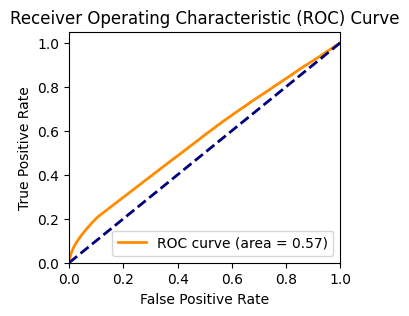

In [90]:
def plot_roc(model, dataloader):
    model.eval()
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for data, labels,_ ,_ in dataloader:
            outputs = model(data.float(), )
            probs = outputs.cpu().numpy()
            
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels).flatten()
    all_probs = np.array(all_probs).flatten()

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # np.save("fpr_method.npy", fpr)
    # np.save("tpr_method.npy", tpr)

    # Plot ROC curve
    plt.figure(figsize=(3.5, 3))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

model_mlp.load_state_dict(torch.load('saved_files/best_baseline_1_model.pth'))
plot_roc(model_mlp, test_dataloader)

In [35]:
for a,b,c,d in train_dataloader:
    break

In [36]:
a

tensor([[-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-